## Import the libraries

In [60]:
import pandas as pd
import numpy as np
from numpy import asarray
import scipy.io
from datetime import datetime, timedelta

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from numpy import asarray


import keras

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, load_model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics

from keras.models import model_from_json
import matplotlib.pyplot as plt

import gc

In [35]:
#restore the dataframe
%store -r df

In [36]:
df.head()

,full_path,gender,age
0,[17/10000217_1981-05-05_2009.jpg],1.0,28
2,[12/100012_1948-07-03_2008.jpg],1.0,60
4,[16/10002116_1971-05-31_2012.jpg],0.0,41
5,[02/10002702_1960-11-09_2012.jpg],0.0,52
6,[41/10003541_1937-09-27_1971.jpg],1.0,34


In [37]:
#clean up the memory
gc.collect()

20

In [38]:
#build a function to get image pixels
target_size = (224, 224)
 
def get_pixels(image_path):
    img = image.load_img("/Users/kalz/Desktop/imdb-wiki/wiki_crop/%s" % image_path[0], grayscale=False, target_size=target_size)
    return asarray(img).reshape(1, -1)[0]

In [39]:
#map function to image path to collect pixels
df['pixels'] = df['full_path'].apply(get_pixels)
df.head()

,full_path,gender,age,pixels
0,[17/10000217_1981-05-05_2009.jpg],1.0,28,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
2,[12/100012_1948-07-03_2008.jpg],1.0,60,"[92, 97, 91, 89, 94, 90, 91, 96, 92, 94, 98, 9..."
4,[16/10002116_1971-05-31_2012.jpg],0.0,41,"[61, 30, 10, 61, 30, 10, 61, 30, 10, 61, 30, 1..."
5,[02/10002702_1960-11-09_2012.jpg],0.0,52,"[97, 122, 178, 97, 122, 178, 97, 122, 178, 97,..."
6,[41/10003541_1937-09-27_1971.jpg],1.0,34,"[190, 189, 194, 204, 203, 208, 203, 202, 207, ..."


In [40]:
#using keras, onehot encode the age column with respective classes
classes = 101  
target = df['age'].values
target_classes = keras.utils.to_categorical(target, classes)

In [41]:
gc.collect()

40

In [42]:
#reshape the features
features = []
for i in range(0, df.shape[0]):
    features.append(df['pixels'].values[i])
 
features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

In [43]:
features.shape

(22138, 224, 224, 3)

In [44]:
gc.collect()

60

In [45]:
#convert features datatype to float
features = features.astype('float32')

In [46]:
features.dtype

dtype('float32')

### Train Test Split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(features, target_classes, test_size=0.30)

In [48]:
gc.collect()

80

In [49]:
# The current range of X_train and X_test is 0 to 255.
# The code below is equivalent to X_train = X_train / 255.
# This scales each value to be between 0 and 1.

X_train /= 255
X_test /= 255

In [19]:
X_train.shape

(15496, 224, 224, 3)

In [20]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [21]:
#pre-trained weights of vgg-face model.
model.load_weights('/Users/kalz/Desktop/imdb-wiki/vgg_face_weights.h5')

In [22]:
model.layers[-4].output

<tf.Tensor 'dropout_2/cond/Identity:0' shape=(None, 1, 1, 4096) dtype=float32>

In [23]:
model.layers[:-7]

In [24]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False
    
base_model_output = Sequential()

#replace the last output layer
base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

age_model = Model(inputs=model.input, outputs=base_model_output)

In [64]:
#check trainable layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.layers.convolutional.ZeroPadding2D object at 0x1a3c5c5c50> False
<keras.layers.convolutional.Conv2D object at 0x1a3e5ce2d0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x1a3e54ddd0> False
<keras.layers.convolutional.Conv2D object at 0x1a3e555110> False
<keras.layers.pooling.MaxPooling2D object at 0x1a3e555a10> False
<keras.layers.convolutional.ZeroPadding2D object at 0x1a3ce8bed0> False
<keras.layers.convolutional.Conv2D object at 0x1a3ce92ed0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x1a3cea3810> False
<keras.layers.convolutional.Conv2D object at 0x1a3cea8210> False
<keras.layers.pooling.MaxPooling2D object at 0x1a3cea8710> False
<keras.layers.convolutional.ZeroPadding2D object at 0x1a3ce8b5d0> False
<keras.layers.convolutional.Conv2D object at 0x1a3ceedad0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x1a3cef1a10> False
<keras.layers.convolutional.Conv2D object at 0x1a3cea4f90> False
<keras.layers.convolutional.ZeroPadding2D object

In [26]:
age_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy']
                 )
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

In [2]:
# gc.collect()

In [28]:
checkpointer = ModelCheckpoint(filepath='age_classification_model',
                               monitor = "val_loss", 
                               verbose=1, 
                               save_best_only=True, 
                               mode = 'auto')

In [29]:
scores = []


epochs = 100
batch_size = 256

for i in range(epochs):
    print("epoch ",i)
        
    ix_train = np.random.choice(X_train.shape[0], size=batch_size)
        
    score = age_model.fit(
                            X_train[ix_train], 
                            y_train[ix_train],
                            epochs=1,
                            validation_data=(X_test, y_test),
                            callbacks=[checkpointer, early_stop]
                         )
        
    scores.append(score)
age_model.save_weights('age_model_weights')

epoch  0
Train on 256 samples, validate on 6642 samples
Epoch 1/1
256/256 [==============================] - 828s 3s/step - loss: 4.5083 - accuracy: 0.0391 - val_loss: 4.2874 - val_accuracy: 0.0283

Epoch 00001: val_loss improved from inf to 4.28740, saving model to age_classification_model
epoch  1
Train on 256 samples, validate on 6642 samples
Epoch 1/1
256/256 [==============================] - 886s 3s/step - loss: 4.1397 - accuracy: 0.0273 - val_loss: 4.1633 - val_accuracy: 0.0342

Epoch 00001: val_loss improved from 4.28740 to 4.16328, saving model to age_classification_model
epoch  2
Train on 256 samples, validate on 6642 samples
Epoch 1/1
256/256 [==============================] - 854s 3s/step - loss: 4.0333 - accuracy: 0.0664 - val_loss: 4.0110 - val_accuracy: 0.0411

Epoch 00001: val_loss improved from 4.16328 to 4.01096, saving model to age_classification_model
epoch  3
Train on 256 samples, validate on 6642 samples
Epoch 1/1
256/256 [==============================] - 832s 3s

256/256 [==============================] - 1126s 4s/step - loss: 3.5243 - accuracy: 0.0547 - val_loss: 3.5640 - val_accuracy: 0.0524

Epoch 00001: val_loss did not improve from 3.50929
epoch  61
Train on 256 samples, validate on 6642 samples
Epoch 1/1
256/256 [==============================] - 1133s 4s/step - loss: 3.5507 - accuracy: 0.0391 - val_loss: 3.5174 - val_accuracy: 0.0536

Epoch 00001: val_loss did not improve from 3.50929
epoch  62
Train on 256 samples, validate on 6642 samples
Epoch 1/1
256/256 [==============================] - 1183s 5s/step - loss: 3.5288 - accuracy: 0.0742 - val_loss: 3.5268 - val_accuracy: 0.0509

Epoch 00001: val_loss did not improve from 3.50929
epoch  63
Train on 256 samples, validate on 6642 samples
Epoch 1/1
256/256 [==============================] - 1177s 5s/step - loss: 3.5719 - accuracy: 0.0547 - val_loss: 3.5365 - val_accuracy: 0.0544

Epoch 00001: val_loss did not improve from 3.50929
epoch  64
Train on 256 samples, validate on 6642 samples
Ep


Epoch 00001: val_loss did not improve from 3.50771
epoch  93
Train on 256 samples, validate on 6642 samples
Epoch 1/1
256/256 [==============================] - 857s 3s/step - loss: 3.5674 - accuracy: 0.0664 - val_loss: 3.5070 - val_accuracy: 0.0596

Epoch 00001: val_loss improved from 3.50771 to 3.50705, saving model to age_classification_model
epoch  94
Train on 256 samples, validate on 6642 samples
Epoch 1/1
256/256 [==============================] - 875s 3s/step - loss: 3.5639 - accuracy: 0.0781 - val_loss: 3.5218 - val_accuracy: 0.0521

Epoch 00001: val_loss did not improve from 3.50705
epoch  95
Train on 256 samples, validate on 6642 samples
Epoch 1/1
256/256 [==============================] - 833s 3s/step - loss: 3.4929 - accuracy: 0.0664 - val_loss: 3.5270 - val_accuracy: 0.0542

Epoch 00001: val_loss did not improve from 3.50705
epoch  96
Train on 256 samples, validate on 6642 samples
Epoch 1/1
256/256 [==============================] - 821s 3s/step - loss: 3.6347 - accuracy:

In [32]:
for i in scores:
    print(i.history)

{'val_loss': [4.287395644137673], 'val_accuracy': [0.028304727748036385], 'loss': [4.508339822292328], 'accuracy': [0.0390625]}
{'val_loss': [4.163277010069091], 'val_accuracy': [0.034176453948020935], 'loss': [4.1397364139556885], 'accuracy': [0.02734375]}
{'val_loss': [4.01096153058262], 'val_accuracy': [0.041102077811956406], 'loss': [4.0333259999752045], 'accuracy': [0.06640625]}
{'val_loss': [3.916577360135394], 'val_accuracy': [0.03839205205440521], 'loss': [4.037775367498398], 'accuracy': [0.02734375]}
{'val_loss': [3.9095396853397855], 'val_accuracy': [0.040048178285360336], 'loss': [3.8716520369052887], 'accuracy': [0.04296875]}
{'val_loss': [3.8678702478917093], 'val_accuracy': [0.03974706307053566], 'loss': [3.8697162866592407], 'accuracy': [0.03515625]}
{'val_loss': [3.834982372629682], 'val_accuracy': [0.04351099207997322], 'loss': [3.8924324214458466], 'accuracy': [0.046875]}
{'val_loss': [3.8027223198214988], 'val_accuracy': [0.04471544548869133], 'loss': [3.887774795293

In [50]:
#restore the best weights
age_model = load_model("age_classification_model")
age_model.load_weights("/Users/kalz/Desktop/imdb-wiki/age_model_weights.h5")

In [52]:
gc.collect()

20

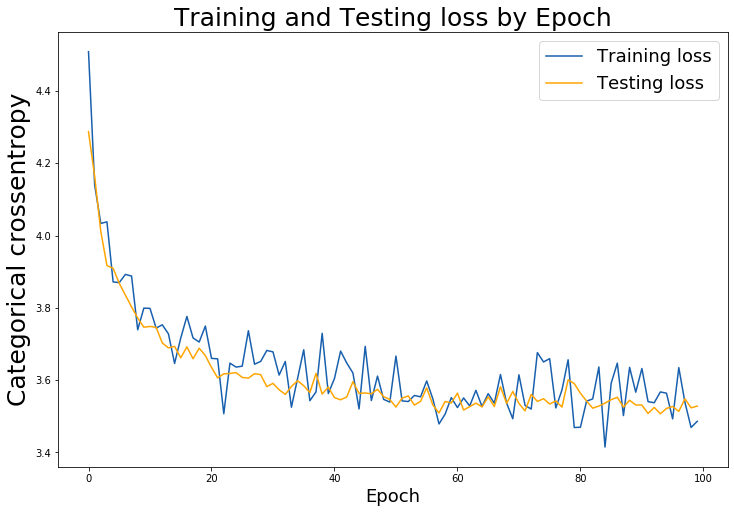

In [38]:
#check out train loss and test loss over epochs
train_loss = []
test_loss = []
for i in range(0,len(scores)):
    train_loss.append(scores[i].history['loss'])
    test_loss.append(scores[i].history['val_loss'])

#set figure size
plt.figure(figsize = (12,8))

#Generate line plot of training, testing loss over epochs
plt.plot(train_loss, label = 'Training loss', color = '#185fad')
plt.plot(test_loss, label = 'Testing loss', color = 'orange')

#set title
plt.title("Training and Testing loss by Epoch", fontsize = 25)
plt.xlabel("Epoch", fontsize = 18)
plt.ylabel("Categorical crossentropy", fontsize = 25)

plt.legend(fontsize = 18);

## Model Evaluation

In [53]:
#Evaluate model on test data.
score = age_model.evaluate(X_test,
                       y_test,
                       verbose = 1)
labels = age_model.metrics_names

#show model performance
print(f"{labels[0]}: {score[0]}")
print(f"{labels[1]}: {score[1]}")

6642/6642 [==============================] - 655s 99ms/step
loss: 3.307457311510214
accuracy: 0.07091237604618073


In [54]:
#make predictions
y_preds = age_model.predict(X_test)

In [55]:
y_preds.shape

(6642, 101)

In [56]:
class_labels =  np.array([i for i in range(0, 101)])

In [57]:
#Actual predictions
y_predictions = np.sum(y_preds * class_labels, axis = 1)

In [58]:
MAE =   0
 
for i in range(0 ,y_predictions.shape[0]):
    prediction = int(y_predictions[i])
    actual = np.argmax(y_test[i])
 
    abs_error = abs(prediction - actual)
 
    MAE = MAE + abs_error
 
MAE = MAE / y_predictions.shape[0]
 
print("mae: ",MAE)
print("instances: ",y_predictions.shape[0])

mae:  5.3861788617886175
instances:  6642


## Testing Model on random images

In [76]:
#create a function to load image with the VGG-face model input dimensions.
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    test_img /= 255
    return test_img

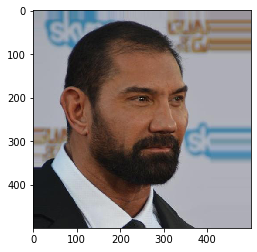

Predicted :  44
Actual Age:  44


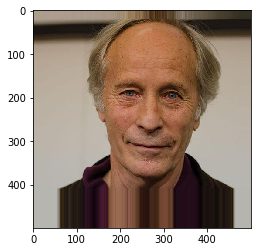

Predicted :  63
Actual Age:  62


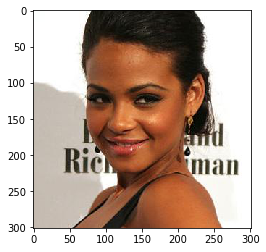

Predicted :  25
Actual Age:  28


In [85]:
pics = ["4.jpg", "2.jpg", "3.jpg"]

for i in pics:
    prediction = age_model.predict(loadImage(i))
    img = image.load_img(i)#, target_size=(224, 224))
    plt.imshow(img)
    plt.show()

    print("Predicted : ",np.argmax(prediction))

    apparent_age = np.round(np.sum(prediction * class_labels, axis = 1))
    print("Actual Age: ", int(apparent_age[0]))